In [172]:
import dill
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tqdm
from keras.layers import Embedding
import numpy as np
from aprec.recommenders.dnn_sequential_recommender.models.sasrec.sasrec import ExpPositionEncoding, SinePositionEncoding
from scipy.spatial import distance 
import matplotlib as mpl
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("talk")


In [173]:
model_file_vanilla = open("./results/ml_benchmark20m_sasrec_variable_importance_2022_11_08T11_45_30//checkpoints/Sasrec-rss-vanilla.dill", "rb")
model_file_rss = open("./results/ml_benchmark20m_sasrec_variable_importance_2022_11_08T11_45_30//checkpoints/Sasrec-rss-lambdarank-0.8-default-causal.dill", "rb")
model_file_bidirectional= open("./results/ml_benchmark20m_sasrec_variable_importance_2022_11_08T11_45_30//checkpoints/Sasrec-rss-lambdarank-0.8-default-bidirectional.dill", "rb")
    

In [174]:
recommender_vanilla = dill.load(model_file_vanilla)
recommender_rss = dill.load(model_file_rss)
recommender_bidirectional = dill.load(model_file_bidirectional)


In [175]:
user_ids = recommender_vanilla.recommender.users.straight

In [176]:
sasrec_recommender_vanilla = recommender_vanilla.recommender
sasrec_recommender_rss = recommender_rss.recommender

In [202]:
def plot_two_maps(map1, map2, title1, title2, vmax=None, save_filename=None):
    f,(ax1,ax2, axcb) = plt.subplots(1,3, gridspec_kw={'width_ratios':[1,1,0.08]}, figsize=(20, 10))
    f.tight_layout()
    cmap = mpl.cm.get_cmap('autumn_r')
    ax1.get_shared_y_axes().join(ax2)
    g1 = sns.heatmap(map1, cmap="YlGnBu", cbar=False, ax=ax1, vmax=vmax)
    g1.set_ylabel('')
    g1.set_xlabel('')
    g1.set_title(title1)
    
    g2 = sns.heatmap(map2, cmap="YlGnBu", cbar_ax=axcb, ax=ax2, vmax=vmax)
    g2.set_ylabel('')
    g2.set_xlabel('')
    g2.set_title(title2)
    if save_filename is not None:
        f.savefig(save_filename)

    

In [203]:
def get_attention_maps(user_id, model, layer=0):
    inputs = model.get_model_inputs(user_id)[0]
    with tf.device('/cpu:0'):
        seq, attn = model.model.get_seq_embedding(inputs)
    return attn[layer][0].numpy()

def plot_attention_maps(model1, model_name1, model2, model_name2, layer=0):
    user_lens = {}
    for key in user_ids.keys():
        uid = user_ids[key]
        n_items = len(model1.user_actions[uid])
        if n_items > 50:
            user_lens[key] = n_items
    maps1 = []
    maps2 = []
    while len(maps1) < 1000:
        uid = np.random.choice(list(user_lens.keys()))
        maps1.append(get_attention_maps(uid, model1, layer))
        maps2.append(get_attention_maps(uid, model2, layer))
    mean_attentions1 = np.mean(maps1, axis=0)
    mean_attentions2 = np.mean(maps2, axis=0)
    plot_two_maps(mean_attentions1, mean_attentions2, model_name1, model_name2, 0.06)
    #sns.heatmap(mean_attentions1, vmax=0.06, cmap="Greens")

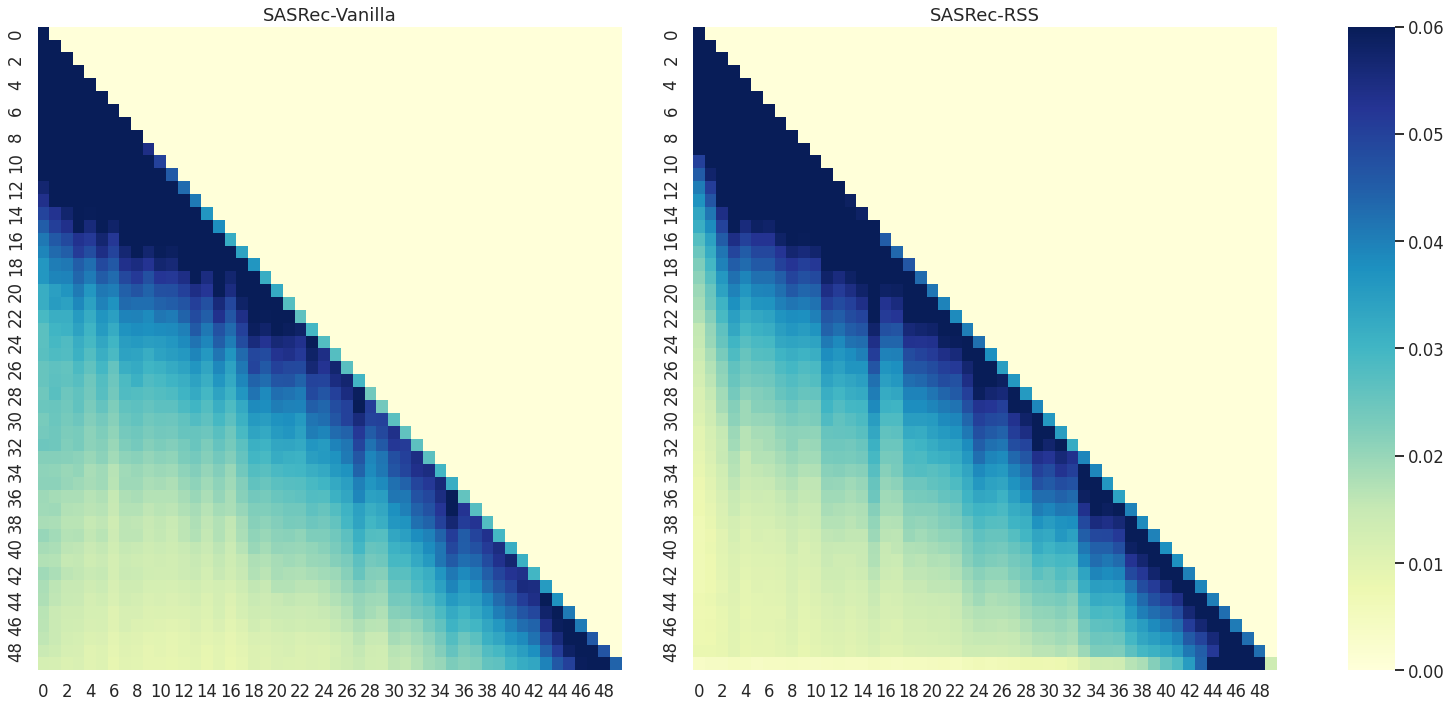

In [204]:
plot_attention_maps(sasrec_recommender_vanilla, "SASRec-Vanilla", sasrec_recommender_rss, "SASRec-RSS", layer=0)

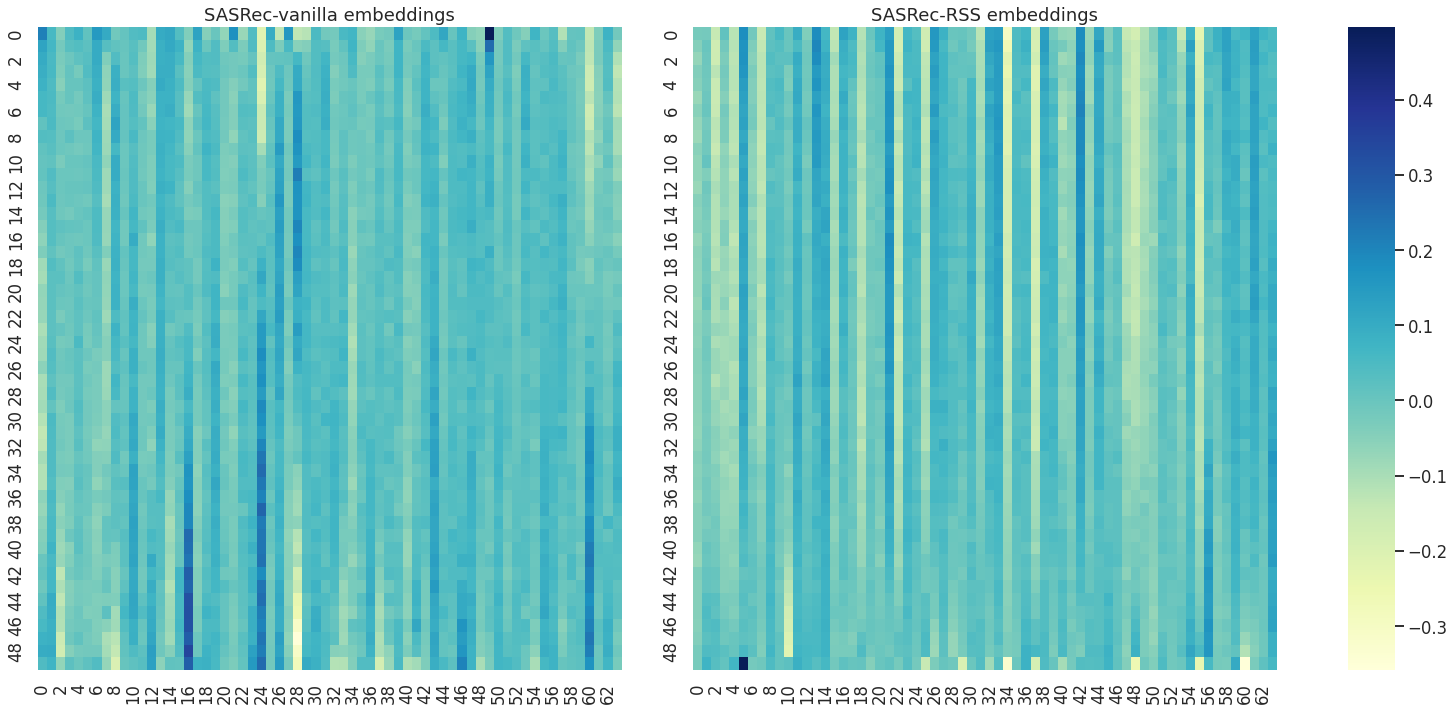

In [205]:
all_items = np.arange(50)
embs_vanilla = recommender_vanilla.recommender.model.postion_embedding_layer(all_items)
#encoder = ExpPositionEncoding(49, 64, 1)
#encoder = SinePositionEncoding(49,64)
#embs = encoder(all_items)
embs_rss = recommender_rss.recommender.model.postion_embedding_layer(all_items)

plot_two_maps(embs_vanilla, embs_rss, "SASRec-vanilla embeddings", "SASRec-RSS embeddings", vmax=None)


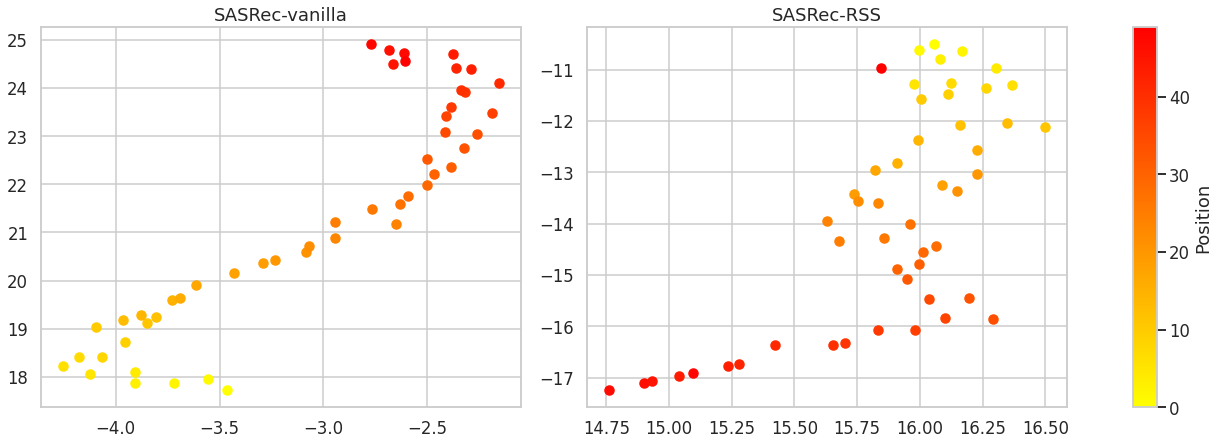

In [206]:
from umap import UMAP
def plot_umap_embeddings(embeddings1, title1, embeddings2, title2,seed=107):
    embeddings = tf.concat([embeddings1, embeddings2], 0)
    mapper = UMAP(n_components=2, metric="cosine", random_state=seed).fit(embeddings)
    matr1 = mapper.embedding_[:len(embeddings1)]
    matr2 = mapper.embedding_[len(embeddings1):]
    N = len(embeddings1)
    cmap = mpl.cm.get_cmap('autumn_r')
    norm = mpl.colors.Normalize(vmin=0, vmax=len(embeddings1) - 1)
    fig, ax = plt.subplots(1,3,figsize=(20, 7), gridspec_kw={'width_ratios': [1, 1, 0.05]})
    for i in range(len(embeddings1)):
        emb1 = matr1[i]
        emb2 = matr2[i]
        color = cmap(norm(i))
        ax[0].scatter(emb1[0], emb1[1], color=color)
        ax[1].scatter(emb2[0], emb2[1], color=color)
    ax[0].set_title(title1)
    ax[1].set_title(title2)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[2], orientation='vertical', label='Position')
    fig.savefig(f'umap_embeddings.svg')
    
plot_umap_embeddings(embs_vanilla, "SASRec-vanilla", embs_rss, "SASRec-RSS", 107)

In [207]:
def pos_sim(emb1, emb2):
    dist = distance.cosine(emb1, emb2)
    return dist

def sim_matr(embs):
    result = []
    for i in range(len(embs)):
        result.append([])
        emb1 = embs[i]
        for j in range(len(embs)):
            emb2 = embs[j]
            result[-1].append(pos_sim(emb1, emb2))
    return np.array(result)

def k_sims(embs, pos, k):
    cnt = 0
    s = 0
    for i in range(pos - k, pos+k):
        for j in range(i+1, pos+k+1):
            s += pos_sim(embs[i], embs[j])
            cnt +=1
    return s/cnt

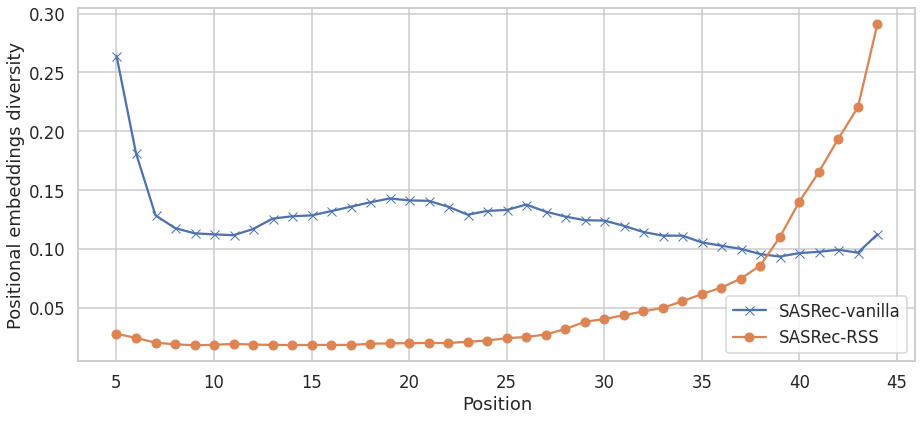

In [208]:
k = 5
x = []
y_vanilla = []
y_rss = []
for i in range(k, len(embs_vanilla)-k):
    x.append(i)
    y_vanilla.append(k_sims(embs_vanilla, i, k))
    y_rss.append(k_sims(embs_rss, i, k))
plt.figure(figsize=(15,6.5))
plt.plot(x, y_vanilla, label="SASRec-vanilla", marker="x")
plt.plot(x, y_rss, label="SASRec-RSS", marker="o")
plt.xlabel("Position")
plt.ylabel("Positional embeddings diversity")
plt.legend()
plt.savefig("embeddings_diversity.svg")

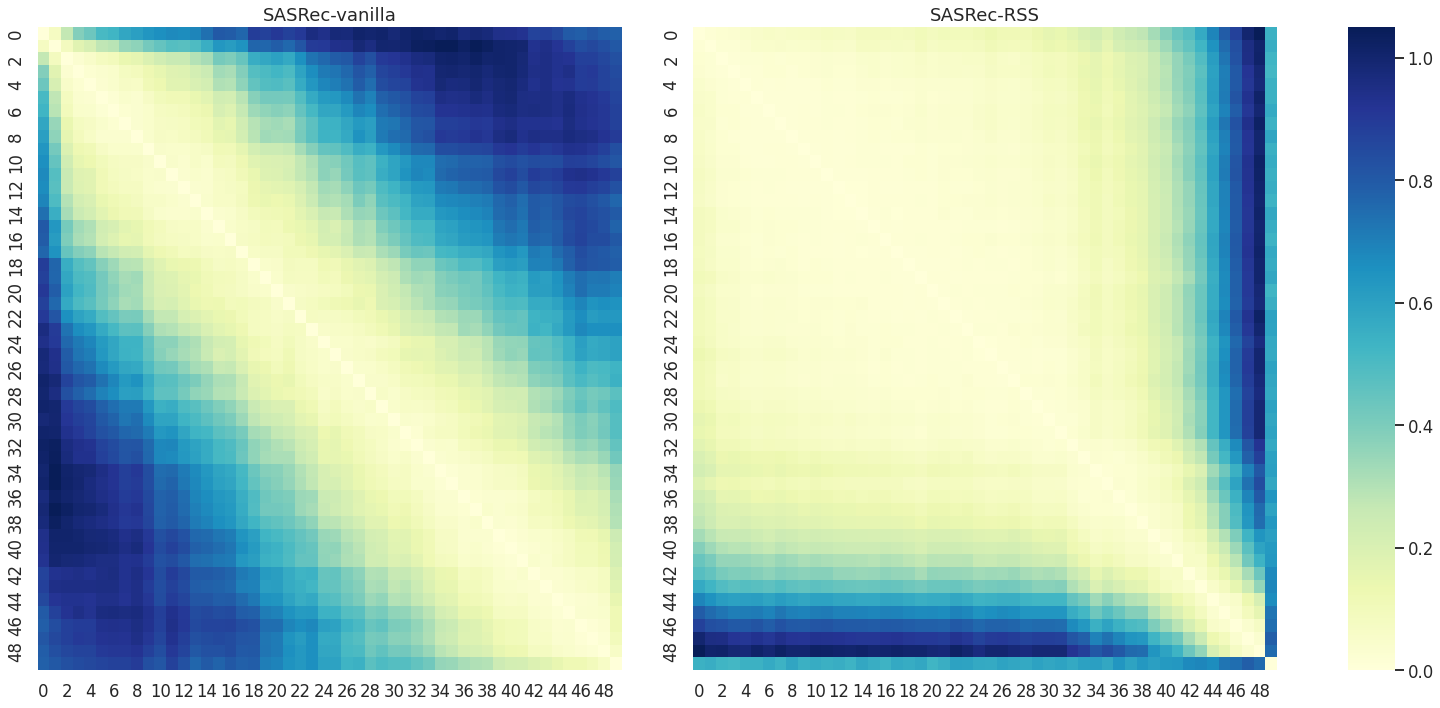

In [209]:
plot_two_maps(sim_matr(embs_vanilla), sim_matr(embs_rss), "SASRec-vanilla", "SASRec-RSS", vmax=None, save_filename="position_similarity_maps.svg")

In [210]:
class SinePositionEncoding(keras.layers.Layer):
    def __init__(
        self,
        seq_length, 
        hidden_size,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength
        self.seq_length = seq_length
        self.hidden_size = hidden_size
    
    def call(self, positions):
        seq_length = self.seq_length
        hidden_size = self.hidden_size
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )
        return tf.gather(positional_encodings, positions)


In [92]:
class ExpPositionalEncoding(keras.layers.Layer):
    def __init__(self, seq_len, emb_size, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.emb_size = emb_size
        pows_initalizer = tf.random_uniform_initializer(-3, 3)
        self.pow = tf.Variable(initial_value=pows_initalizer(shape=(emb_size, )), trainable=True)
        
    
    def __call__(self, positions):
        w = tf.exp(self.pow)
        for i in range(len(positions.shape)):
            w = tf.expand_dims(w, 0)
        tiles = list(positions.shape) + [1]
        w = tf.tile(w, tiles)
        positions_norm = tf.cast((positions+1), 'float32')/(self.seq_len+1)
        pos = tf.tile(tf.expand_dims(positions_norm, -1), [1] * len(positions.shape) + [self.emb_size])
        return tf.pow(pos, w)